In [34]:
from pathlib import Path

import matplotlib.pyplot as plt

import seaborn as sns
from tqdm.notebook import tqdm
from collections import namedtuple
import torch

from eval import read_run_dir
from new_eval import new_get_run_metrics, get_config, baseline_data, LoadInfo, new_get_run_metrics2
from plot_utils import basic_plot
from typing import List

%matplotlib inline
%load_ext autoreload
%autoreload 2
sns.set_theme('notebook', 'darkgrid')
palette = sns.color_palette('colorblind')

models_dir = Path("../models")
device = "cpu" # Set to "cuda" if needed

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [35]:
df = read_run_dir(models_dir)
df  # list all the runs in our run_dir

../models/soft_prompting/52f6994e-746c-46bf-a2b8-cbaa401a9c29
../models/soft_prompting/c048e08c-c0ce-4675-a344-a15e0497d4ef
../models/soft_prompting/738134a8-4ce7-4511-b12b-286661ca444c
../models/soft_prompting/fa639c10-14f4-48d7-a4d9-6af80dcebc2f
../models/soft_prompting/8f94cfa2-a055-4aa6-86b0-3f077db9219a
../models/soft_prompting/a3cc2f66-d50b-405d-992a-78bdc78890dd
../models/kernel_linear_regression/bigger_model
../models/kernel_linear_regression/small-1-11-5M-steps
../models/soft_prompting_small_back/prompt_dim_11
../models/soft_prompting_small_back/prompt_dim_31
../models/soft_prompting_small_back/prompt_dim_41
../models/soft_prompting_small_back/prompt_dim_51
../models/soft_prompting_small_back/prompt_dim_21
../models/soft_prompting_noisy/prompt_dim_100
../models/soft_prompting_noisy/prompt_dim_80
../models/soft_prompting_noisy/prompt_dim_60
../models/soft_prompting_noisy/prompt_dim_90
../models/soft_prompting_noisy/prompt_dim_50
../models/soft_prompting_noisy/prompt_dim_70
../m

,run_id,task,model,kwargs,num_tasks,num_examples,n_dims,n_layer,n_head,run_name
5,a3cc2f66-d50b-405d-992a-78bdc78890dd,soft_prompting,50_prompting_degree_5,basis_dim=5_degree=5,-1,-1,1,6,4,50_prompting_degree_5
0,52f6994e-746c-46bf-a2b8-cbaa401a9c29,soft_prompting,50_prompting_shared,basis_dim=5_degree=5,-1,-1,1,6,4,50_prompting_shared
3,fa639c10-14f4-48d7-a4d9-6af80dcebc2f,soft_prompting,big_prompting_degree_5,basis_dim=5_degree=5,-1,-1,1,6,4,big_prompting_degree_5
2,738134a8-4ce7-4511-b12b-286661ca444c,soft_prompting,big_prompting_shared,basis_dim=5_degree=5,-1,-1,1,6,4,big_prompting_shared
6,bigger_model,kernel_linear_regression,Transformer-small,basis_dim=11_different_degrees=True_lowest_deg...,-1,-1,1,6,4,chebyshev_linear_regression_toy
7,small-1-11-5M-steps,kernel_linear_regression,Transformer-small,basis_dim=11_different_degrees=True_lowest_deg...,-1,-1,1,6,4,chebyshev_linear_regression_toy
20,base_model_noisy,polynomial_regression,Transformer-small,basis_dim=11_different_degrees=True_highest_de...,-1,-1,1,6,4,chebyshev_regression_noisy
19,base_model_nopos,polynomial_regression,Transformer-small,basis_dim=11_different_degrees=True_highest_de...,-1,-1,1,6,4,chebyshev_regression_nopos
30,34f86826-cd70-4feb-800d-8fc840564a9a,lora,lora_full_degree_5,basis_dim=5_degree=5,-1,-1,1,6,4,lora_full_degree_5
28,ee3104f0-1923-484e-a9fe-c09549a91c1d,lora,lora_full_shared_roots,basis_dim=5_degree=5,-1,-1,1,6,4,lora_full_shared_roots


In [36]:
def plot_collection(load_info_collection: List[LoadInfo], device: str = "cuda", yhigh_lim: float = float('inf'), baselines: List[str] = None):
    metrics = {}
    for path, step, alt_path, alternative_name, name_addon in load_info_collection:
        conf = get_config(path / "config.yaml")
        name = alternative_name if alternative_name != "" else conf.wandb.name + "/" + conf.training.task + name_addon
        metrics[name] = new_get_run_metrics(path, step=step, include_noise=False, device=device, alternative_train_conf_path=alt_path)

    if baselines is not None:
        train_conf_path = load_info_collection[0].alternative_train_conf_path if load_info_collection[0].alternative_train_conf_path is not None else load_info_collection[0].path / "config.yaml"
        baseline_mets = baseline_data(train_conf_path, device=device, include_noise=False)
        metrics.update({key: baseline_mets[key] for key in baselines if key in baseline_mets})
    
    basic_plot(metrics, yhigh_lim=yhigh_lim)
    plt.show()

../models/kernel_linear_regression/bigger_model/config.yaml
Attention 0


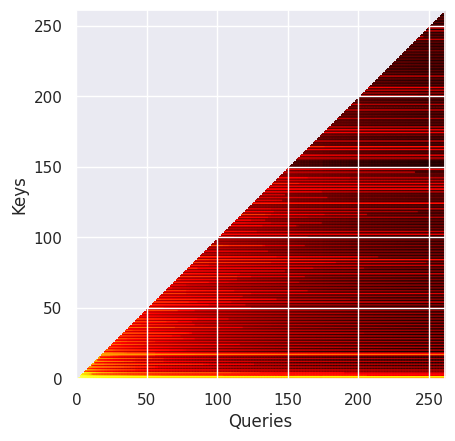

Attention 1


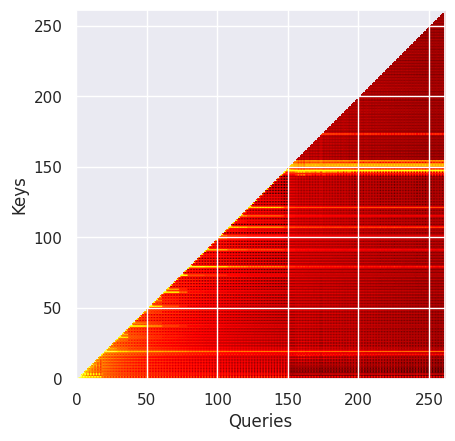

Attention 2


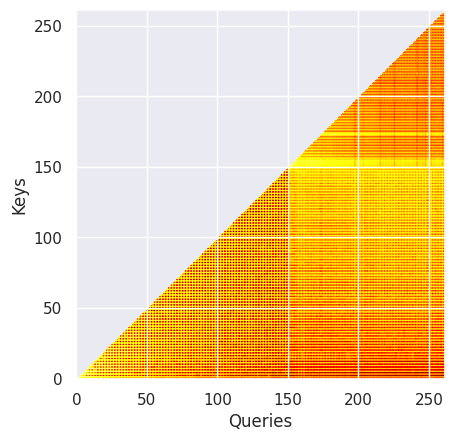

Attention 3


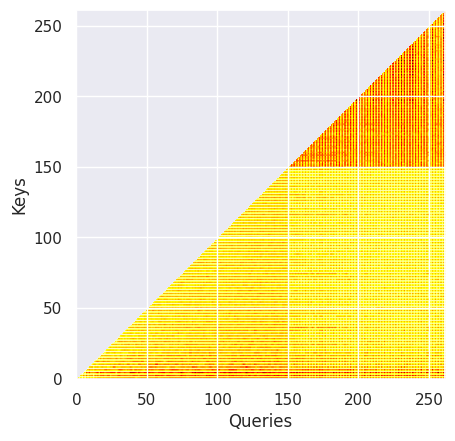

Attention 4


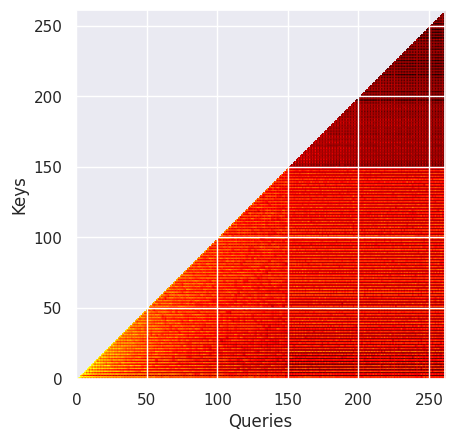

Attention 5


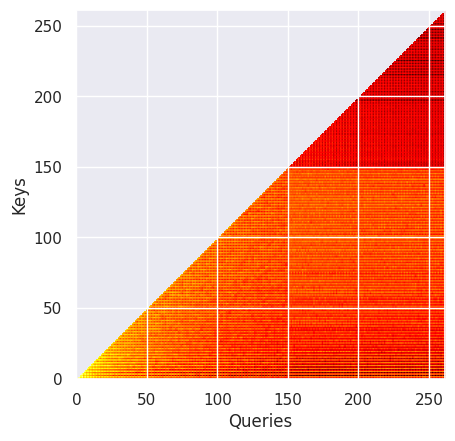

In [51]:
# Plot for comparing "comparable" soft-prompts and LoRA for degree 5
model_path = LoadInfo(path=models_dir / "kernel_linear_regression" / "bigger_model", step=-1,
                                                alternative_name="Original Model")

vals, attent = new_get_run_metrics2(model_path.path, step=-1, device=device)

for i, att_l in enumerate(attent):
    print(f"Attention {i}")
    a = att_l.detach().cpu()
    a = torch.log(a.mean(dim=(0,1)))
    a = a[::2, ::2].T
    #a = torch.flip(a.transpose(0, 1), [0])
    #print(a.shape)
    plt.imshow(a, cmap='hot', origin='lower')
    plt.xlabel("Queries")
    plt.ylabel("Keys")
    #plt.gca.invert_yaxis()
    plt.show()